# Torch with Pretrained Weigths and Encoder

### In this project, my purpose is to applying segmentation to water bodies. Feel free to check my repo on github...

### https://github.com/uraninjo/SatelliteWaterBodies



In [13]:
!pip install --upgrade opencv-contrib-python
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=230ed4d5ad54655b5844f85526f7f4aa5f53c3a2cfb16302169cfd86856d6156
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=f251219044d49b999672467f1496713106adc33650fa10bef49e09f893eb2a5b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A

height,width = (256, 256)


torch.cuda.is_available()

True

**Before our model preperation, we need to edit the data and we need to make the photo the shape we want for our model.**

**For this, we create a class for ourselves and write the functions we want in it.**

In [15]:
# !kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies
# !unzip satellite-images-of-water-bodies

In [16]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])


    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        mask = Image.open(self.masks_path[idx]).convert('L')

        img,mask=np.array(img),np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask

    def __len__(self):
        return self.len

**We load the data with glob as X-Y...**

In [17]:
X = sorted(glob.glob("/content/Water Bodies Dataset/Images/*"))
y = sorted(glob.glob("/content/Water Bodies Dataset/Masks/*"))

**We need to check the existence of the data we are uploading. If a wrong path is entered here, our result below will be 0.**

In [18]:
len(y)

2841

**We seperate our data for train and validation and shape it with our above class.**

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [20]:
train_dataset = LoadData(X_train, y_train)
valid_dataset = LoadData(X_val, y_val)

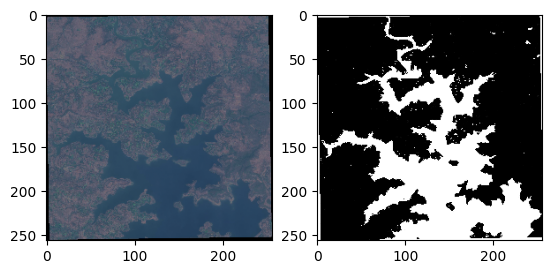

In [21]:
img, mask = train_dataset[18]

f, axarr = plt.subplots(1,2)
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))


**This settings are customizable you could change it as you want. Encoder selection is important, your results will be according to it...**

In [22]:
DEVICE='cuda'

EPOCHS=45
BATCH_SIZE=32
LR=0.001

ratio=0.5 #Various ratios could perform better for visualization
sample_num=18

ENCODER='resnet50'
WEIGHTS='imagenet'

**We load the data with DataLoader...**

In [23]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)


**Here we determine the encoder and weights from the above variables in Unet.**

**The value of our loss function is the sum of the DiceLoss and BCEWithLogitsLoss.**

In [24]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [25]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc=smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1,loss2
        return logits

In [26]:
model=SegmentationModel()
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 249MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

**We write the function to be used for training and eval so that things are simplified in the training cycle.**

In [27]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    total_bceloss=0.0
    for images ,masks in tqdm(data_loader):
        images=images.to(DEVICE, dtype=torch.float32)
        masks=masks.to(DEVICE, dtype=torch.float32)

        optimizer.zero_grad()

        logits,diceloss,bceloss=model(images,masks)
        diceloss.backward(retain_graph=True)
        bceloss.backward()
        optimizer.step()
        total_diceloss+=diceloss.item()
        total_bceloss+=bceloss.item()


    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [28]:
def eval_fn(data_loader,model):
    model.eval()
    total_diceloss=0.0
    total_bceloss=0.0
    with torch.no_grad():
        for images ,masks in tqdm(data_loader):
            images=images.to(DEVICE, dtype=torch.float32)
            masks=masks.to(DEVICE, dtype=torch.float32)

            logits,diceloss,bceloss=model(images,masks)
            total_diceloss+=diceloss.item()
            total_bceloss+=bceloss.item()

        #Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader))
            image=image[sample_num]
            mask=mask[sample_num]
            logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio)*1.0
            f, axarr = plt.subplots(1,3)
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)


In [29]:
optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
#torch.optim.Adam(model.parameters(),lr=LR)

**We use the adam optimizer and set up our training loop.**

**Here we want to save the best model and see our loss at every step...**

In [ ]:
best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)

    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')
    if valid_dice < best_val_dice_loss or valid_bce < best_val_bce_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print('Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce

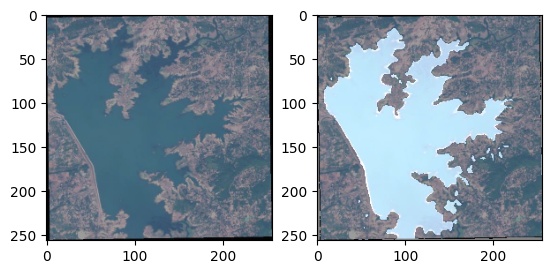

In [68]:
num=11
ratio=0.5

model.load_state_dict(torch.load('./best_model.pt'))

for i in range(1):
  image,mask = next(iter(valid_loader))
  image=image[sample_num]
  mask=mask[sample_num]

  logits_mask = model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask > ratio)*1.0

# Get numpy arrays
  image = image.cpu().numpy().transpose(1, 2, 0).astype(np.float32)
  mask = pred_mask.detach().cpu().numpy().squeeze().astype(np.float32)

# Make 3 channel mask
  mask = np.dstack([mask]*3)

# Merge mask and image
  merged = cv2.addWeighted(image, 1, mask, 0.5, 0)

# Display only original and merged
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(image)
axarr[1].imshow(merged)

plt.show()